In [1]:
import torch.nn as nn
import torch
import einops

from einops import rearrange
from einops.layers.torch import Rearrange

import random
import h5py
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

from torch.optim import AdamW

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [2]:
from src.dataset import AllenCahnDataset
from src.ViTPDE import ViTPDE

In [3]:
training_samples = 256
batch_size = 16

train_dataset = AllenCahnDataset(which="train", training_samples = training_samples)
val_dataset = AllenCahnDataset(which="val")

train_loader  = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)


Text(0.5, 1.0, 'Output')

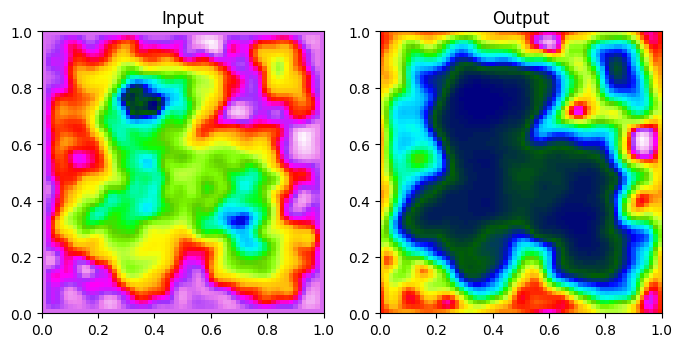

In [4]:
input, output = next(iter(train_loader))
input = input[0,0].numpy()
output = output[0,0].numpy()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(input, cmap = "gist_ncar", extent=(0,1,0,1),)
axes[0].set_title("Input")
axes[1].imshow(output, cmap = "gist_ncar", extent=(0,1,0,1),)
axes[1].set_title("Output")


In [5]:
image_size = 64
patch_size = 16
dim = 128
depth = 4
heads = 4
dim_head = 32
emb_dropout = 0.0

model = ViTPDE(image_size = image_size,
            patch_size = patch_size,
            dim = dim,
            depth = depth,
            heads = heads,
            mlp_dim = 256,
            channels = 1,
            dim_head = dim_head,
            emb_dropout = emb_dropout)

model.print_size()



Total number of model parameters: 597898)


597898

In [6]:
X = torch.rand(16,1,64,64)
Y = model(X)

In [7]:
optimizer = AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 200, eta_min=10**-6)
l = nn.L1Loss()

epoch = 200

freq_print = 1
for epoch in range(epoch):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        output_pred_batch = model(input_batch)
        loss_f = l(output_pred_batch, output_batch) / l(output_batch, torch.zeros_like(output_batch))
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(train_loader)

    scheduler.step()
    with torch.no_grad():
        model.eval()
        test_relative_l1 = 0.0
        for step, (input_batch, output_batch) in enumerate(val_loader):
            output_pred_batch = model(input_batch)
            loss_f = (torch.mean((abs(output_pred_batch - output_batch))) / torch.mean(abs(output_batch))) * 100
            test_relative_l1 += loss_f.item()
        test_relative_l1 /= len(val_loader)

    if epoch % freq_print == 0: print("## Epoch:", epoch, " ## Train Loss:", train_mse, "## Rel L1 Test Norm:", test_relative_l1, "LR: ", scheduler.get_lr())



/home/ajeet/miniconda3/envs/distributedsystems/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:1779: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


## Epoch: 0  ## Train Loss: 1.5051712393760681 ## Rel L1 Test Norm: 140.31560516357422 LR:  [0.0009999383779245895]
## Epoch: 1  ## Train Loss: 1.3379973471164703 ## Rel L1 Test Norm: 130.78636932373047 LR:  [0.0009997535269026829]
## Epoch: 2  ## Train Loss: 1.2532027140259743 ## Rel L1 Test Norm: 122.5004301071167 LR:  [0.000999445492543504]
## Epoch: 3  ## Train Loss: 1.1714394018054008 ## Rel L1 Test Norm: 113.63891696929932 LR:  [0.0009990143508499217]
## Epoch: 4  ## Train Loss: 1.0772153362631798 ## Rel L1 Test Norm: 103.38748359680176 LR:  [0.0009984602081996976]
## Epoch: 5  ## Train Loss: 0.9640094712376595 ## Rel L1 Test Norm: 89.95205211639404 LR:  [0.0009977832013192385]
## Epoch: 6  ## Train Loss: 0.815569169819355 ## Rel L1 Test Norm: 74.51690483093262 LR:  [0.0009969834972498623]
## Epoch: 7  ## Train Loss: 0.6779271699488163 ## Rel L1 Test Norm: 63.13438701629639 LR:  [0.0009960612933065818]
## Epoch: 8  ## Train Loss: 0.5695998407900333 ## Rel L1 Test Norm: 54.2840809

In [8]:

save_path = "ViTPDE_AllenCahn.pth"

torch.save({
    'epoch': epoch,                      # last epoch number
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_f,                        # last loss value
}, save_path)

print(f"Model saved to {save_path}")

Model saved to ViTPDE_AllenCahn.pth


Text(0.5, 1.0, 'Prediction')

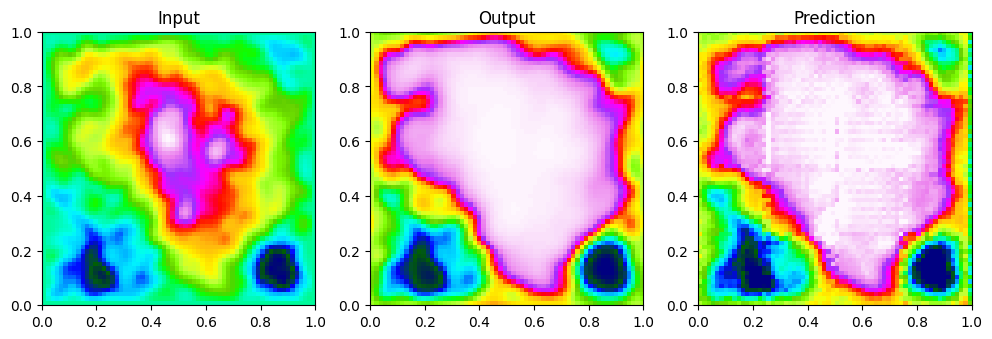

In [9]:
input, output = next(iter(val_loader))
pred = model(input)
input = input[0,0].numpy()
output = output[0,0].numpy()
pred = pred[0,0].detach().numpy()

vmin = np.min(output)
vmax = np.max(output)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(input, cmap = "gist_ncar", extent=(0,1,0,1),)
axes[0].set_title("Input")
axes[1].imshow(output, cmap = "gist_ncar", extent=(0,1,0,1), vmin = vmin, vmax= vmax)
axes[1].set_title("Output")
axes[2].imshow(pred, cmap = "gist_ncar", extent=(0,1,0,1), vmin = vmin, vmax= vmax)
axes[2].set_title("Prediction")


In [10]:
# Recreate the model with same architecture
model = ViTPDE(image_size=image_size,
               patch_size=patch_size,
               dim=dim,
               depth=depth,
               heads=heads,
               mlp_dim=256,
               channels=1,
               dim_head=dim_head,
               emb_dropout=emb_dropout)

# If GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Recreate optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Load checkpoint
checkpoint = torch.load("ViTPDE_AllenCahn.pth", map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
loss = checkpoint['loss']

print(f"Model restored, resuming training from epoch {start_epoch}")


Model restored, resuming training from epoch 199


In [11]:
model.load_state_dict(torch.load("ViTPDE_AllenCahn.pth")['model_state_dict'])
model.eval()


ViTPDE(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (patch_to_image): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): Rearrange('b (h w) (p1 p2 c) -> b c (h p1) (w p2)', p1=16, p2=16, h=4)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): TransformerBlock(
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-3): 4 x ModuleList(
        (0): AttensionBlock(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.2, inplace=False)
          (to_qkv): Linear(in_features=128, out_features=384,

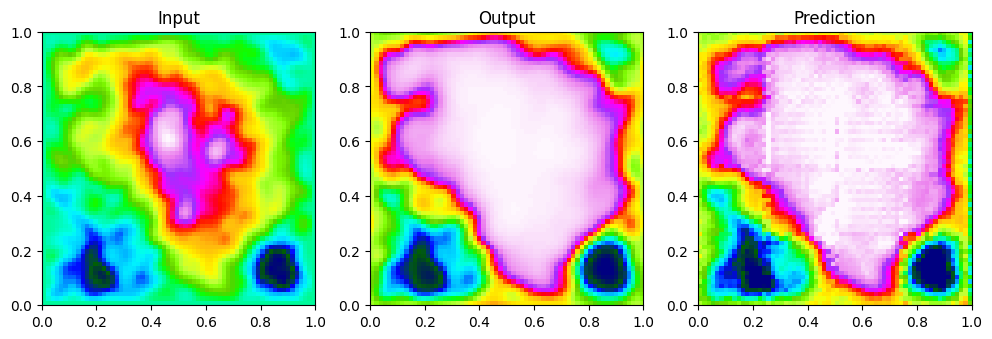

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Load one batch
inputs, outputs = next(iter(val_loader))

# Move to same device
inputs = inputs.to(device)
outputs = outputs.to(device)

# Forward pass
with torch.no_grad():
    pred = model(inputs)

# Convert back to CPU for numpy/plotting
input_img = inputs[0,0].cpu().numpy()
output_img = outputs[0,0].cpu().numpy()
pred_img = pred[0,0].cpu().numpy()

# Plot
vmin = np.min(output_img)
vmax = np.max(output_img)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(input_img, cmap="gist_ncar", extent=(0,1,0,1))
axes[0].set_title("Input")

axes[1].imshow(output_img, cmap="gist_ncar", extent=(0,1,0,1), vmin=vmin, vmax=vmax)
axes[1].set_title("Output")

axes[2].imshow(pred_img, cmap="gist_ncar", extent=(0,1,0,1), vmin=vmin, vmax=vmax)
axes[2].set_title("Prediction")

plt.show()
